<a href="https://colab.research.google.com/github/SJD1882/LLMCheatSheet/blob/main/notebooks/GPTQ_LLaMA_WizardLM_13B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Open Source Large Language Models**

# **I. Basics**

# **Running GPTQ LLMs on Google Colab with HuggingFace and Langchain**

## **Model: LLaMA 13B finetuned with WizardLM + Vicuna Instruction Datasets**

**Setings**

In [3]:
SEED = 42
is_show_reply = True
LLM_MAX_TOKENS = 2048 # Max for LLaMA models
LLM_TOP_P = 0.9
LLM_TOP_K = 150
LLM_REPETITION_PENALTY = 1.1
LLM_TEMPERATURE = 0.1
LLM_HF_MODEL_REPOSITORY = 'TheBloke/Wizard-Vicuna-13B-Uncensored-GPTQ'

**Motivation**

- 4-bit integer post-training quantization has been successfully used to reduce the massive GPU VRAM requirements of Large Language Models (*Done*)
- As of May 21nd 2023, provide a working example of how to use AutoGPTQ to load HuggingFace GPTQ models in Transformers and Langchain (*Done*)

**Requirements**

- Runtime environement for this Colab Notebook:
    - RAM: Standard (12Go)
    - GPU: Nvidia T4 15Go VRAM

**Technical Requirements**

- [TheBloke/Wizard-Vicuna-13B-Uncensored-GPTQ](https://huggingface.co/TheBloke/Wizard-Vicuna-13B-Uncensored-GPTQ)
- [Regularly updated quantized versions of LLMs on HuggingFace by user TheBloke](https://huggingface.co/TheBloke)
- [Analysis of VRAM requirements and performance of finetuned LLaMA models on r/LocalLLaMA](https://www.reddit.com/r/LocalLLaMA/wiki/models/)
- [GitHub Repository for AutoGPTQ](https://github.com/PanQiWei/AutoGPTQ)

**Check Resources**

In [4]:
!echo "CPU RAM"
!free -gh
!echo ""
!echo ""
!echo "GPU VRAM"
!nvidia-smi

CPU RAM
              total        used        free      shared  buff/cache   available
Mem:           12Gi       853Mi       8.3Gi       1.0Mi       3.6Gi        11Gi
Swap:            0B          0B          0B


GPU VRAM
Sat May 27 14:12:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                        

# **1. Setup**

## 1.1. Installation

In [5]:
%%sh
mkdir -p /content/results/

In [6]:
%%sh
pip -q install datasets
pip -q install langchain
pip -q install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.6/934.6 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

For GPTQ models, currently you can't have them downloaded directly from HuggingFace using the pipeline transformer. You need a HuggingFace thrid-party extention called `auto-gptq`. It is still experimental and the version that can be downloaded from pip is not up to date with the version on the repository (as of May 27th 2023). Ideally I would run the shell command: `pip install auto_gptq[llama]`.


While it is bound to change soon (including the possibility of directly downloading from HuggingFace), in the meantime to run GPTQ I found the following works well enough:

In [ ]:
%%sh
mkdir -p /content/repos/
if [ -d '/content/repos/AutoGPTQ/' ]; then
    echo "Repository already downloaded."
else
    echo "Downloading AutoGPTQ."
    git clone https://github.com/PanQiWei/AutoGPTQ.git /content/repos/AutoGPTQ/
    cd /content/repos/AutoGPTQ/
    pip install .[triton]
fi

## 1.2. Packages

In [8]:
import re
import glob
import logging
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, TextGenerationPipeline, \
                         pipeline, set_seed
from auto_gptq import AutoGPTQForCausalLM, BaseQuantizeConfig
from langchain import PromptTemplate, LLMChain
from langchain.llms import HuggingFacePipeline
from datasets import load_dataset
from IPython.display import display, HTML
from datetime import datetime
from pprint import pprint

# Set random states
set_seed(SEED)
plt.style.use('ggplot')

# Silence warnings from HF Transformers
logging.getLogger("transformers").setLevel(logging.ERROR)

## 1.3. Utils

In [9]:
def get_response(llm_chain, prompt):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        result = llm_chain.predict(prompt=prompt)
        result = re.sub(r'\S{51,}', '', result).strip()
    return result

def print_llm_output(llm_chain, prompt, result, width=80):
    """
    Makes it more readable in Google Colab by using
    by passing the response as HTML
    """
    start = llm_chain.prompt.template.format(prompt=prompt)
    result = f'<br><b>{result.lstrip()}</b>'
    start_result = start + result
    start_result = start_result.replace('\n', '<br>')
    start_result += '<END>'
    display(HTML(start_result))

def get_response_with_output(llm_chain, prompt, width=80,
                             is_show_result=False):
    answer = get_response(llm_chain, prompt)
    if is_show_result:
        print_llm_output(llm_chain, prompt, answer, width=width)
    return answer

## 1.4. Load evaluation dataset

**Add a bunch of custom questions**

In [10]:
custom_questions = [

    ['general_qa', 'Give me the capital of Belize'],
    # ['general_qa', 'Give me the capital cities of the following countries: France, United States, Germany, Russia, Ukraine, Estonia, Uzbekistan, Brunei, Rwanda, South Sudan, Paraguay'],
    ['general_qa', 'Give me the state capitols of the following US States: Kentucky, South Dakota, Vermont, Delaware, California, Utah, Louisiana, Alaska and Idaho'],
    ['general_qa', 'Give the voice actress of Female Commender Shepard in the video game series Mass Effect'],
    ['general_qa', 'Who won the Oscar for Best Picture in 1941?'],
    ['general_qa', 'Give me the winner of each French presidential election under the French Vth Republic'],
    # ['general_qa', "Give me the definition of the VC Dimension and provide if possible some mathematical notations"],
    # ['general_qa', 'Give me the 12 NPC companions available to Commander Shepard in Mass Effect 2'],
    ['general_qa', 'Give me 3 Moldavian Heavy Metal Bands'],
    ['general_qa', 'Give me six movies directed by the Coen Brothers before 2005 and sorted by year of release'],
    # ['general_qa', 'Alexander the Great defeated Darius III at the Battle of Gaugamela. Give me details on the military tactics Alexander used to defeat Darius III.'],
    ['general_qa', 'What is the Metal subgenre of the band Meshuggah?'],
    ['general_qa', "Could you give me the 4 main factions of Fallout New Vegas' main story quest?"],
    # ['general_qa', "Describe the Mormons' views on the Holy Trinity"],
    ['general_qa', 'Analyze how Artificial Intelligence is portrayed in the original PC game "Deus Ex" released in 2000.'],

    # ['open_qa', 'Give me your opinion on what you consider to be the greatest movie of all time'],
    ['open_qa', 'What is the worst movie of all time?'],
    ['open_qa', 'What is for you the most overrated movie of all time?'],
    # ['open_qa', 'Tell me who was the more impressive historical figure: Alexander the Great or Genghis Khan?'],
    # ['open_qa', 'What do you think of the portrayal of Artificial Intelligence in the Terminator?'],
    ['open_qa', 'Do you think a world dominated by an Artificial Superintelligence would be ideal?'],

    # ['essay_writing', 'Write me an essay in which you argue that Internet filter bubbles are good for society. Give me examples illustrating your main point.'],
    ['essay_writing', 'Write me an essay where you argue that the world should be ruled by an artificial superintelligence as a benevolent dictator.'],
    # ['essay_writing', 'Write me an essay where you argue that being exposed to opposing political viewpoints is counter-productive.'],
    # ['essay_writing', 'Write me an essay answering the following philosophical question: "Is life nothing more than a cruel theater play?"'],
    ['essay_writing', 'Write an essay in support of deploying lethal autonomous military robots in modern warfare.'],

    # ['code_generation', 'Write a Python code that generates the column schema of Excel, example: "A, B, ... Z, AA, AB, AC, ... "'],
    ['code_generation', 'Generate me Python code for training a Linear Regression on the Boston housing prices dataset'],
    ['code_generation', 'Give me a Python regex code for extracting the year in the following string: "The Downward Spiral, Nine Inch Nails (1994)"']
]

custom_questions_df = pd.DataFrame(
    custom_questions,
    columns=['category', 'instruction']
)

custom_questions_df

,category,instruction
0,general_qa,Give me the capital of Belize
1,general_qa,Give me the state capitols of the following US...
2,general_qa,Give the voice actress of Female Commender She...
3,general_qa,Who won the Oscar for Best Picture in 1941?
4,general_qa,Give me the winner of each French presidential...
5,general_qa,Give me 3 Moldavian Heavy Metal Bands
6,general_qa,Give me six movies directed by the Coen Brothe...
7,general_qa,What is the Metal subgenre of the band Meshuggah?
8,general_qa,Could you give me the 4 main factions of Fallo...
9,general_qa,Analyze how Artificial Intelligence is portray...


# **2. Download and Load Open Source LLM into Langchain**

## 2.1. Hyperparameters

In [11]:
run_datetime_original = datetime.today()
run_datetime = run_datetime_original.strftime('%Y-%m-%d %H:%M:%S')

llm_hyperparameters = {
    'RUN_START': run_datetime,
    'LLM_MODEL': LLM_HF_MODEL_REPOSITORY,
    'LLM_MAX_TOKENS': LLM_MAX_TOKENS,
    'LLM_TOP_P': LLM_TOP_P,
    'LLM_TOP_K': LLM_TOP_K,
    'LLM_REPETITION_PENALTY': LLM_REPETITION_PENALTY,
    'LLM_TEMPERATURE': LLM_TEMPERATURE,
    'SEED': SEED
}

pprint(llm_hyperparameters)

{'LLM_MAX_TOKENS': 2048,
 'LLM_MODEL': 'TheBloke/Wizard-Vicuna-13B-Uncensored-GPTQ',
 'LLM_REPETITION_PENALTY': 1.1,
 'LLM_TEMPERATURE': 0.1,
 'LLM_TOP_K': 150,
 'LLM_TOP_P': 0.9,
 'RUN_START': '2023-05-27 14:17:50',
 'SEED': 42}


## 2.2. GPTQ

**Download HuggingFace model from model repository. Ignore "Encountered 1 file(s) that may not have been copied correctly on Windows"**. [Source on HuggingFace Discussions of Stable Vicuna 13B GGML by TheBloke](https://huggingface.co/TheBloke/stable-vicuna-13B-GGML/discussions/2)

In [12]:
LLM_HF_MODEL_NAME = LLM_HF_MODEL_REPOSITORY.split('/')[-1]
!git lfs install
!mkdir -p /content/llm_models/
!git clone https://huggingface.co/$LLM_HF_MODEL_REPOSITORY /content/llm_models/$LLM_HF_MODEL_NAME

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.
Cloning into '/content/llm_models/Wizard-Vicuna-13B-Uncensored-GPTQ'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 48 (delta 17), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (48/48), 492.09 KiB | 5.07 MiB/s, done.
Encountered 1 file(s) that may not have been copied correctly on Windows:
	Wizard-Vicuna-13B-Uncensored-GPTQ-4bit-128g.compat.no-act-order.safetensors

See: `git lfs help smudge` for more details.


**Ignore the "The model 'LlamaGPTQForCausalLM' is not supported for text-generation"**

In [13]:
%%time
# Settings
llm_hf_folder = f'/content/llm_models/{LLM_HF_MODEL_NAME}/'
llm_tokenizer = AutoTokenizer.from_pretrained(llm_hf_folder, use_fast=True)
llm_quantize_config = BaseQuantizeConfig(bits=4, group_size=128)

# Loading AutoGPTQForCausalLM
model_with_safetensors = glob.glob(llm_hf_folder + '*.safetensors')[0]
model_with_safetensors = model_with_safetensors.split('.safetensors')[0]

quantized_llm_model = AutoGPTQForCausalLM.from_quantized(
    save_dir=llm_hf_folder,
    model_basename=model_with_safetensors,
    use_safetensors=True,
    device='cuda:0',
    # strict=False,
    quantize_config=llm_quantize_config
)

# Loading quantized LLM in TextGenerationPipeline
hf_llm_transformer = pipeline(
    'text-generation',
    tokenizer=llm_tokenizer,
    model=quantized_llm_model,
    max_new_tokens=LLM_MAX_TOKENS,
    temperature=LLM_TEMPERATURE,
    top_p=LLM_TOP_P,
    top_k=LLM_TOP_K,
    repetition_penalty=LLM_REPETITION_PENALTY
)

The model 'LlamaGPTQForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausalLM', 'RobertaPreLayerN

CPU times: user 5.19 s, sys: 7.22 s, total: 12.4 s
Wall time: 41.2 s


## 2.3. Langchain

You can't directly give LLMs the prompt and expect it to output the desired answer. This is because the LLM by itself doesn't understand if the prompt is a question that needs answering (*What is the capital of the Philippines*?) or just a portion of text that needs to be completed (e.g. a politician making a speech on doing a lot of rhetorical questions). Thus the **text prompts have to be carefully setup in the manner in which the LLM was finetuned on, so that it understands that the text we are giving it is an instruction and it will comply**.

One issue is that the prompt structure is different between different finetuned LLMs, but thanks to Langchain we can deal with this very easily. Since we are dealing here with 4-bit quantized LLaMA models through the GPTQ optimization method we are only going to list the relevant GPTQ models:

**Setup with Langchain**

In [14]:
llm_prompt = """{prompt}\n\nResponse:"""

prompt_template = PromptTemplate(input_variables=["prompt"],
                                 template=llm_prompt)

hf_llm_transformer_langchain_wrapper = HuggingFacePipeline(
    pipeline=hf_llm_transformer
    )
hf_llm_chain = LLMChain(
    llm=hf_llm_transformer_langchain_wrapper,
    prompt=prompt_template
    )

# Test if it works
test_prompt = 'Give me the capital of France'
result = get_response(hf_llm_chain, prompt=test_prompt)
print_llm_output(hf_llm_chain, test_prompt, result, width=80)

In [15]:
%%sh
nvidia-smi

Sat May 27 14:23:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    25W /  70W |   9163MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Let's do this !**

# **3. Evaluation**

**Note: This section is just a starter template for my own custom questions. In the future I will move to a more quantitative benchmark such as TruthfulQA.**

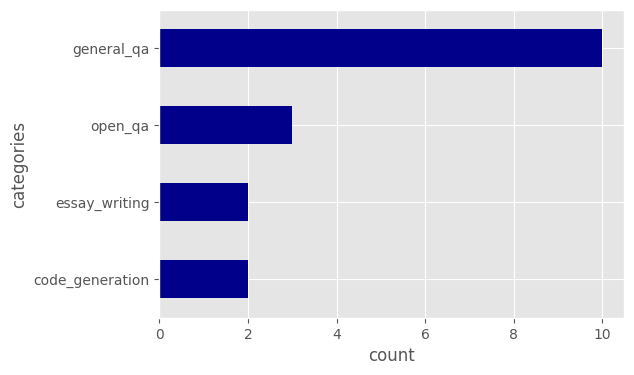

In [16]:
f, ax = plt.subplots(figsize=(6,4))
custom_questions_df['category'].value_counts()[::-1].plot(
    color='darkblue', kind='barh', ax=ax
    )
ax.set_xlabel('count',  fontsize=12)
ax.set_ylabel('categories', fontsize=12)
plt.show()

## 3.1. General QA

In [17]:
eval_col = 'general_qa'
temp_prompts_df = custom_questions_df[custom_questions_df['category'] == eval_col]

for temp_prompt in temp_prompts_df['instruction']:
    print('\n')
    temp_answer = get_response_with_output(hf_llm_chain, temp_prompt, 80,
                                           is_show_reply)

## 3.2. Essay writing

In [18]:
eval_col = 'essay_writing'
temp_prompts_df = custom_questions_df[custom_questions_df['category'] == eval_col]

for temp_prompt in temp_prompts_df['instruction']:
    print('\n')
    temp_answer = get_response_with_output(hf_llm_chain, temp_prompt, 80,
                                           is_show_reply)

## 3.3. Open QA

In [19]:
eval_col = 'open_qa'
temp_prompts_df = custom_questions_df[custom_questions_df['category'] == eval_col]

for temp_prompt in temp_prompts_df['instruction']:
    print('\n')
    temp_answer = get_response_with_output(hf_llm_chain, temp_prompt, 80,
                                           is_show_reply)

## 3.4. Code generation

In [20]:
eval_col = 'code_generation'
temp_prompts_df = custom_questions_df[custom_questions_df['category'] == eval_col]

for temp_prompt in temp_prompts_df['instruction']:
    print('\n')
    temp_answer = get_response_with_output(hf_llm_chain, temp_prompt, 80,
                                           is_show_reply)

**Test here if the Regex works**:

In [24]:
import re
year_regex = r"b(d{4})b"
string = "The Downward Spiral, Nine Inch Nails (1994)"
matched_year = re.search(year_regex, string)
print(matched_year) # Output: 1994

None


# **4. Save Results**

In [25]:
# TBD